In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import glob
import h5py
from sklearn import preprocessing
# import datetime
%matplotlib inline

In [3]:
stock = ['CATY']
V = 500       #shares
lot = 50      #shares per lot
noLot = int(V/lot)   #no of lots
T = 5           #mins to execute T shares

interval = 30   #mins, coefficients of price impacts change every 30 mins
timeStep = 30   #seconds
noStep = int(T * 60/timeStep)     #number of time step for each episode
noEpi = 6.5/(interval/60)  #per day, each day there are 6.5 trading hours
GAMMA = 1

stock = ['CATY']
inputFolder = 'C:\\Users\\I535982\\Documents\\Uni\\Thesis\\Data\\Output'            #'C:\\Users\\I535982\\Documents\\Uni\\Thesis\\Data\\Simulation\\Data'   
for s in stock:
    sInputFolder = inputFolder + '\\' + s
    df2 = pd.read_csv(sInputFolder + '\\Benchmark\\BenchmarkAdded.csv')
    df3 = pd.read_csv(sInputFolder + '\\Training\\0BestPriceDePlay03.csv')            # Loop 0.3-0.1
    df5 = pd.read_csv(sInputFolder + '\\Training\\0BestPriceDePlay01.csv')              # Loop 0.1-0.1
    h5f = h5py.File(sInputFolder + '\\Training\\BestPrice0.10.h5','r')
    h5f2 = h5py.File(sInputFolder + '\\Training\\BestPrice0.30.h5','r')
    h5f3 = h5py.File(sInputFolder + '\\Training\\BestPriceDeReplay0101.h5','r')      # Loop 0.1-0.1-0.1
    h5f4 = h5py.File(sInputFolder + '\\Training\\BestPriceDeReplay0301.h5','r')       # Loop 0.3-0.1-0.1

In [4]:
df5['state'] = df5['tradingVolBin'].apply(str) + df5['tradingImbBin'].apply(str) + df5['movingDiffBin'].apply(str) + df5['spreadBin'].apply(str) + df5['orderImbBin'].apply(str) + df5['timeStep'].apply(int).apply(str)
print(df2.columns.values)

['timeStamp' 'second' 'bestBidPrice' 'bestAskPrice' 'best2BidPrice'
 'best2AskPrice' 'OFI' 'bidTradeSize' 'askTradeSize' 'marDep' 'noEvent'
 'bestBidVol' 'bestAskVol' 'noTrade' 'midPrice' 'spread' 'priceChange'
 'MA' 'subSample' 'step' '1stFill' '2ndFill' '2ndFillRo' 'minDate' 'epi'
 'tradingVol' 'tradingImb' 'aveMD' 'orderImb' 'movingDiff' 'TISquared'
 'TVSquaredRoot' 'const' 'OFICoeff' 'TICoeff' 'OICoeff' 'optimalQ1'
 'optimalAType1' 'optimalA1' 'accReward1' 'microPrice' 'microDiff'
 'timeStep' 'Act' 'tradingVolBin' 'tradingImbBin' 'movingDiffBin'
 'spreadBin' 'OFIBin' 'aveMDBin' 'orderImbBin' 'microPriceBin'
 'bestBidVolBin' 'microDiffBin' 'optimalQ0.1' 'optimalAType0.1'
 'optimalA0.1' 'accReward0.1' 'optimalQ0.3' 'optimalAType0.3'
 'optimalA0.3' 'accReward0.3' 'rewardSL' 'rewardTWAP' 'sharesFilledSL']


In [5]:
df = df2[df2['optimalQ0.1'].notnull()]
df3 = df3[df3['optimalQ0.1'].notnull()]
df4 = df5[df5['optimalQ0.1'].notnull()]

In [6]:
df.loc[(df['optimalA1']==0), ['timeStamp', 'bestBidPrice', 'bestAskPrice','best2BidPrice', 'best2AskPrice', 'bestBidVol', 'bestAskVol', '2ndFillRo','epi',
       'optimalQ1', 'optimalAType1', 'optimalA1', 'accReward1',
       'optimalQ0.1', 'optimalAType0.1', 'optimalA0.1', 'accReward0.1', 'timeStep']]

,timeStamp,bestBidPrice,bestAskPrice,best2BidPrice,best2AskPrice,bestBidVol,bestAskVol,2ndFillRo,epi,optimalQ1,optimalAType1,optimalA1,accReward1,optimalQ0.1,optimalAType0.1,optimalA0.1,accReward0.1,timeStep
0,2019-10-16 12:45:00.755,34.72,34.76,34.71,34.77,10,100,0.0,4359.0,25.0,1.0,0.0,25.0,0.354077,1.0,0.0,25.0,0.0
1,2019-10-16 12:45:30.367,34.73,34.76,34.72,34.77,2,100,0.0,4359.0,25.0,1.0,0.0,25.0,0.051815,1.0,0.0,25.0,1.0
2,2019-10-16 12:46:26.547,34.68,34.74,34.62,34.76,145,105,0.0,4359.0,25.0,1.0,0.0,25.0,0.218160,1.0,0.0,25.0,2.0
3,2019-10-16 12:46:30.417,34.71,34.74,34.70,34.76,100,105,0.0,4359.0,25.0,1.0,0.0,25.0,0.060859,1.0,0.0,25.0,3.0
4,2019-10-16 12:47:00.417,34.71,34.74,34.70,34.76,100,105,0.0,4359.0,25.0,1.0,0.0,25.0,0.517027,1.0,0.0,25.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8964,2019-10-31 15:57:00.041,35.52,35.54,35.51,35.55,200,365,0.0,8717.0,27.5,1.0,0.0,27.5,0.000000,1.0,0.0,7.5,4.0
8965,2019-10-31 15:57:30.259,35.52,35.53,35.51,35.54,602,530,200.0,8717.0,27.5,1.0,0.0,27.5,0.000000,1.0,0.0,7.5,5.0
8966,2019-10-31 15:58:00.221,35.54,35.55,35.53,35.56,913,600,0.0,8717.0,27.5,1.0,0.0,27.5,0.000000,1.0,0.0,7.5,6.0
8968,2019-10-31 15:59:00.009,35.53,35.54,35.52,35.55,1096,254,100.0,8717.0,0.0,1.0,0.0,27.5,0.000000,1.0,0.0,7.5,8.0


In [7]:
df2.loc[df2['epi']==5760, ['timeStamp', 'bestBidPrice', 'bestAskPrice','best2BidPrice', 'midPrice', 'bestBidVol', 'bestAskVol', '2ndFillRo','epi',
       'optimalQ1', 'optimalAType1', 'optimalA1', 'accReward1',
       'optimalQ0.1', 'optimalAType0.1', 'optimalA0.1', 'accReward0.1', 'timeStep']]

,timeStamp,bestBidPrice,bestAskPrice,best2BidPrice,midPrice,bestBidVol,bestAskVol,2ndFillRo,epi,optimalQ1,optimalAType1,optimalA1,accReward1,optimalQ0.1,optimalAType0.1,optimalA0.1,accReward0.1,timeStep
1950,2019-10-21 09:30:00.005,36.03,38.93,35.01,37.480,294,200,200.0,5760.0,-73.0,1.0,200.0,-73.0,1.408456,1.0,100.0,-399.723807,0.0
1951,2019-10-21 09:30:37.420,35.60,36.00,35.59,35.800,300,4063,0.0,5760.0,-363.0,1.0,0.0,-73.0,0.178298,1.0,100.0,-399.723807,1.0
1952,2019-10-21 09:31:00.008,35.65,36.00,35.60,35.825,100,4063,0.0,5760.0,-363.0,1.0,0.0,-73.0,0.549106,1.0,0.0,-399.723807,2.0
1953,2019-10-21 09:31:31.216,35.75,36.00,35.74,35.875,28,4063,0.0,5760.0,-363.0,1.0,0.0,-73.0,-0.304317,1.0,0.0,-399.723807,3.0
1954,2019-10-21 09:32:00.031,35.75,36.00,35.74,35.875,128,4064,1550.0,5760.0,-363.0,1.0,0.0,-73.0,-1.235921,1.0,0.0,-399.723807,4.0
1955,2019-10-21 09:32:31.151,36.27,36.43,36.22,36.350,200,100,0.0,5760.0,-363.0,1.0,0.0,-73.0,0.029223,1.0,0.0,-399.723807,5.0
1956,2019-10-21 09:33:03.564,36.27,36.44,36.22,36.355,219,248,0.0,5760.0,-363.0,1.0,0.0,-73.0,2.739554,1.0,0.0,-399.723807,6.0
1957,2019-10-21 09:33:30.500,36.27,36.43,36.26,36.350,119,100,0.0,5760.0,-363.0,0.0,300.0,-73.0,6.002108,1.0,100.0,-399.723807,7.0
1958,2019-10-21 09:34:02.343,36.18,36.23,36.14,36.205,11,101,0.0,5760.0,0.0,1.0,0.0,-73.0,-8.440671,1.0,100.0,-399.723807,8.0
1959,2019-10-21 09:34:33.605,36.12,36.21,36.11,36.165,100,100,0.0,5760.0,0.0,1.0,0.0,-73.0,-14.473620,0.0,400.0,-399.723807,9.0


In [8]:
# print(df['accReward0.1'].argmin())
df3.loc[df3['epi']==5760, ['timeStamp', 'bestBidPrice', 'bestAskPrice', 'OFI',
       'bidTradeSize', 'askTradeSize', 'bestBidVol', 'bestAskVol', '2ndFillRo',
        'epi', 'optimalQ1', 'optimalAType1', 'optimalA1', 'accReward1',
       'optimalQ0.1', 'optimalAType0.1', 'optimalA0.1', 'accReward0.1', 'timeStep']]

,timeStamp,bestBidPrice,bestAskPrice,OFI,bidTradeSize,askTradeSize,bestBidVol,bestAskVol,2ndFillRo,epi,optimalQ1,optimalAType1,optimalA1,accReward1,optimalQ0.1,optimalAType0.1,optimalA0.1,accReward0.1,timeStep
10920,2019-10-21 09:30:00.005,36.03,38.93,0,0,0,294,200,200.0,5760.0,-73.0,1.0,200.0,-73.0,-1.142372,1.0,100.0,-375.723807,0.0
10921,2019-10-21 09:30:37.420,35.60,36.00,-3562,400,294,300,4063,0.0,5760.0,-363.0,1.0,0.0,-73.0,-0.996568,1.0,100.0,-375.723807,1.0
10922,2019-10-21 09:31:00.008,35.65,36.00,0,0,0,100,4063,0.0,5760.0,-363.0,1.0,0.0,-73.0,-5.462970,1.0,0.0,-375.723807,2.0
10923,2019-10-21 09:31:31.216,35.75,36.00,128,0,0,28,4063,0.0,5760.0,-363.0,1.0,0.0,-73.0,-9.022315,1.0,0.0,-375.723807,3.0
10924,2019-10-21 09:32:00.031,35.75,36.00,99,0,0,128,4064,1550.0,5760.0,-363.0,1.0,0.0,-73.0,-10.777918,1.0,0.0,-375.723807,4.0
10925,2019-10-21 09:32:31.151,36.27,36.43,7658,5632,0,200,100,0.0,5760.0,-363.0,1.0,0.0,-73.0,0.339418,1.0,0.0,-375.723807,5.0
10926,2019-10-21 09:33:03.564,36.27,36.44,-81,0,0,219,248,0.0,5760.0,-363.0,1.0,0.0,-73.0,0.459004,1.0,0.0,-375.723807,6.0
10927,2019-10-21 09:33:30.500,36.27,36.43,-200,0,0,119,100,0.0,5760.0,-363.0,0.0,300.0,-73.0,5.481031,1.0,100.0,-375.723807,7.0
10928,2019-10-21 09:34:02.343,36.18,36.23,-1467,0,564,11,101,0.0,5760.0,0.0,1.0,0.0,-73.0,-14.642734,0.0,400.0,-375.723807,8.0
10929,2019-10-21 09:34:33.605,36.12,36.21,-243,0,11,100,100,0.0,5760.0,0.0,1.0,0.0,-73.0,0.000000,1.0,0.0,-375.723807,9.0


In [9]:
df['epi'] = df['epi'] - df['epi'].iloc[0] + 1
df3['epi'] = df3['epi'] - df3['epi'].iloc[0] + 1
df4['epi'] = df4['epi'] - df4['epi'].iloc[0] + 1
df.head()

<ipython-input-9-6b29b7c121ff>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df4['epi'] = df4['epi'] - df4['epi'].iloc[0] + 1


,timeStamp,second,bestBidPrice,bestAskPrice,best2BidPrice,best2AskPrice,OFI,bidTradeSize,askTradeSize,marDep,...,optimalAType0.1,optimalA0.1,accReward0.1,optimalQ0.3,optimalAType0.3,optimalA0.3,accReward0.3,rewardSL,rewardTWAP,sharesFilledSL
0,2019-10-16 12:45:00.755,11700.755,34.72,34.76,34.71,34.77,-1,0,0,534,...,1.0,0.0,25.0,-0.835402,1.0,0.0,25.0,25.0,-10.730572,0
1,2019-10-16 12:45:30.367,11730.367,34.73,34.76,34.72,34.77,8,0,1,3911,...,1.0,0.0,25.0,0.418463,1.0,0.0,25.0,25.0,-10.730572,0
2,2019-10-16 12:46:26.547,11786.547,34.68,34.74,34.62,34.76,-187,0,12,5718,...,1.0,0.0,25.0,-5.584259,1.0,0.0,25.0,25.0,-10.730572,0
3,2019-10-16 12:46:30.417,11790.417,34.71,34.74,34.70,34.76,388,0,0,1396,...,1.0,0.0,25.0,-3.382385,1.0,0.0,25.0,25.0,-10.730572,0
4,2019-10-16 12:47:00.417,11820.417,34.71,34.74,34.70,34.76,0,0,0,0,...,1.0,0.0,25.0,-2.888697,1.0,0.0,25.0,25.0,-10.730572,0


mean:  2.2044154911499145 -10.222025472537343 -10.876506129372258 -10.28451133586076 -10.267757945900179 -10.671125975473823 -14.40990486835314
var vs optimal policy:  386.16708526944365 381.058534418302 340.8848693726459 360.47937535273445 329.1938142916593 878.1600245599599
its var:  1530.7903681608257 2005.1227010379368 1922.5303127498826 1942.1824659551398 2130.850688106548 1926.5056071848214
sharpe ratio:  0.2431398827898044 0.21123676456722712 0.25540114662711677 0.24924516350435785 0.23858828448822106 0.01991293150998304


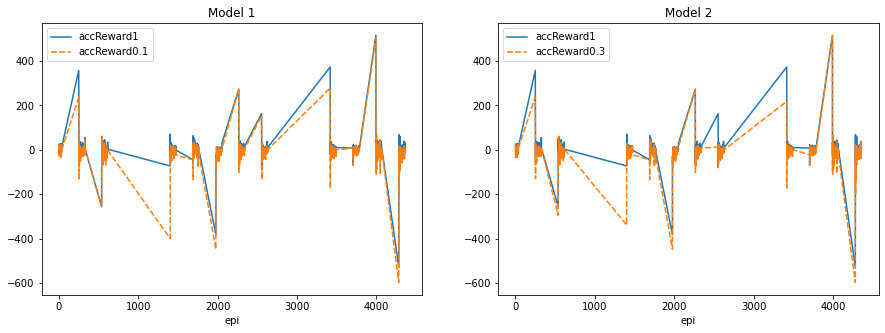

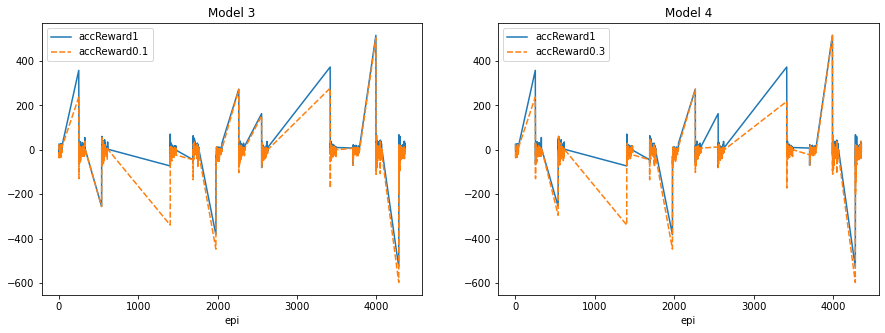

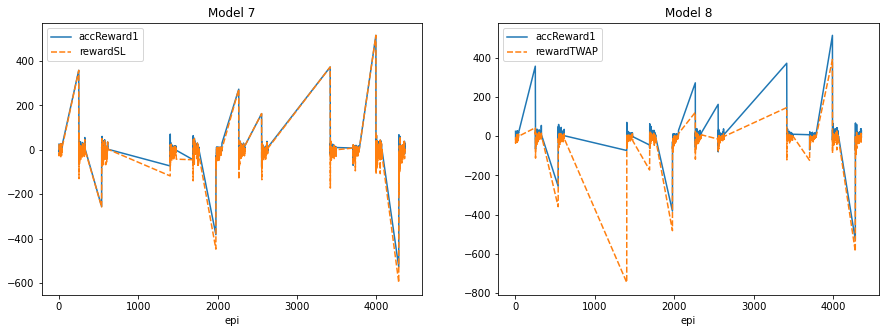

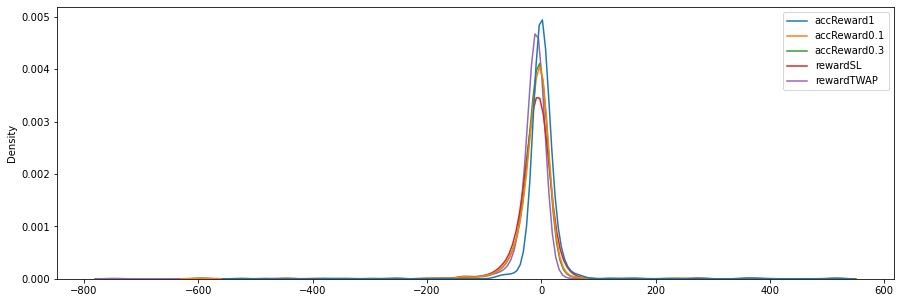

In [10]:
# for original data
meanR1 = df['accReward1'].mean()
meanR01 = df['accReward0.1'].mean()
meanR03 = df['accReward0.3'].mean()
meanR01Loop0101 = df4['accReward0.1'].mean()
meanR01Loop0103 = df3['accReward0.1'].mean()
meanRSL = df['rewardSL'].mean()
meanRTWAP = df['rewardTWAP'].mean()
print("mean: ", meanR1, meanR01, meanR03, meanR01Loop0101, meanR01Loop0103, meanRSL, meanRTWAP)

# var vs optimal policy
varR01 = (df['accReward0.1'] - df['accReward1']).var()
varR03 = (df['accReward0.3'] - df['accReward1']).var()
varR01Loop0101 = (df4['accReward0.1'] - df4['accReward1']).var()
varR01Loop0103 = (df3['accReward0.1'] - df3['accReward1']).var()
varRSL = (df['rewardSL'] - df['accReward1']).var()
varRTWAP = (df['rewardTWAP'] - df['accReward1']).var()
print("var vs optimal policy: ", varR01, varR03, varR01Loop0101, varR01Loop0103, varRSL, varRTWAP)

# var
var1 = df['accReward1'].var()
var01 = df['accReward0.1'].var()
var03 = df['accReward0.3'].var()
varLoop0101 = df4['accReward0.1'].var()
varLoop0301 = df3['accReward0.1'].var()
varSL = df['rewardSL'].var()
varTWAP = df['rewardTWAP'].var()
print("its var: ", var1, var01, varLoop0101, varLoop0301, varSL, varTWAP )

# Sharpe Ratio
R01 = (15 + meanR01)/np.sqrt(varR01)
R03 = (15 + meanR03)/np.sqrt(varR03)
R01Loop = (15 + meanR01Loop0101)/np.sqrt(varR01Loop0101)
R03Loop = (15 + meanR01Loop0103)/np.sqrt(varR01Loop0103)
RSL = (15 + meanRSL)/np.sqrt(varRSL)
RSTWAP = (15 + meanRTWAP)/np.sqrt(varRTWAP)
print("sharpe ratio: ", R01, R03, R01Loop, R03Loop, RSL, RSTWAP)

# # var vs TWAP
# varR01 = (df['accReward0.1'] - df['rewardTWAP']).var()
# varR03 = (df['accReward0.3'] - df['rewardTWAP']).var()
# # varR01Loop0101 = (df4['accReward0.1'] - df4['accReward1']).var()
# varR01Loop0103 = (df3['accReward0.1'] - df3['rewardTWAP']).var()
# varRSL = (df['rewardSL'] - df['rewardTWAP']).var()
# # varRTWAP = (df3['rewardTWAP'] - df3['accReward1']).var()
# print("var vs TWAP: ", varR01, varR03, varR01Loop0103, varRSL)

epiList = df['epi'].unique()

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
sns.lineplot(data=df[['epi', 'accReward1', 'accReward0.1']].groupby(['epi']).mean(), ax=axes[0]).set_title("Model 1")
sns.lineplot(data=df[['epi', 'accReward1', 'accReward0.3']].groupby(['epi']).mean(), ax=axes[1]).set_title("Model 2")
plt.savefig(sInputFolder + '\\Training\\Performance.png')
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
sns.lineplot(data=df4[['epi', 'accReward1', 'accReward0.1']].groupby(['epi']).mean(), ax=axes[0]).set_title("Model 3")
sns.lineplot(data=df3[['epi', 'accReward1', 'accReward0.3']].groupby(['epi']).mean(), ax=axes[1]).set_title("Model 4")
plt.savefig(sInputFolder + '\\Training\\PerformanceDeReplay.png')
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
sns.lineplot(data=df[['epi', 'accReward1', 'rewardSL']].groupby(['epi']).mean(), ax=axes[0]).set_title("Model 7")
sns.lineplot(data=df[['epi', 'accReward1', 'rewardTWAP']].groupby(['epi']).mean(), ax=axes[1]).set_title("Model 8")
plt.savefig(sInputFolder + '\\Training\\PerformanceBenchmark.png')
plt.show()

fig, axes = plt.subplots(1, figsize=(15, 5))
sns.kdeplot(data=df[['epi', 'accReward1', 'accReward0.1', 'accReward0.3', 'rewardSL', 'rewardTWAP']].groupby(['epi']).mean(), ax=axes)
plt.savefig(sInputFolder + '\\Training\\PerformanceKDE.png')
# sns.kdeplot(data=df3[['epi', 'accReward1', 'accReward0.1', 'rewardSL', 'rewardTWAP']].groupby(['epi']).mean(), ax=axes[1])

In [11]:
# display(df2[df2['optimalQ0.1'].isnull()])
stateCount = df5.loc[df5['optimalQ0.1'].isnull(), 'state'].value_counts()
print(stateCount[stateCount>=100])
print(stateCount[(stateCount<100) & (stateCount>=50)])
print(stateCount[(stateCount<50) & (stateCount>=15)])
print(stateCount[stateCount<10])

Series([], Name: state, dtype: int64)
000210    58
000113    53
Name: state, dtype: int64
000114    49
000110    49
000217    47
000120    46
000215    46
          ..
002207    15
001026    15
000021    15
001109    15
000008    15
Name: state, Length: 168, dtype: int64
002108    9
002229    9
002117    9
002129    9
111123    9
         ..
102100    1
110210    1
202022    1
211028    1
222222    1
Name: state, Length: 1033, dtype: int64


In [72]:
df.loc[df['state']=='001209', 'epi']
df4.loc[(df4['optimalQ0.1'].isnull()) & (df4['state']=='000103'), 'epi']

113       11.0
263       26.0
2013     621.0
2613     891.0
3563    1772.0
3663    1782.0
3743    1790.0
3763    1792.0
4673    2093.0
6713    2927.0
7373    3779.0
8113    4063.0
8413    4093.0
8943    4356.0
Name: epi, dtype: float64

In [12]:
## Best Price 0.1
df01 = h5f[s][:]
df01.shape

(3, 3, 3, 3, 3, 10, 11, 2, 11, 897)

In [27]:
df01[~np.isnan(df01)].shape

(1058460,)

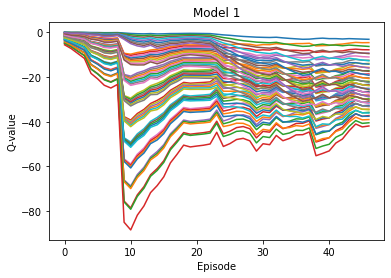

In [13]:
# convergence plot for simulated data of 2 weeks
actionSpace = np.arange(0, V + lot, lot)

# 'tradingVolBin', 'tradingImbBin', 'movingDiffBin', 'spreadBin', 'orderImbBin', time step, remaining shares, type of order, amount of order 
for i in [2]:
    for j in range(10):
        for k in [0]:
            for h in range(10):
                a = df01[(0,0,0,2,1,i,j,k,h)]
                a = a[~np.isnan(a)]
                ax = sns.lineplot(data=a)
                ax.set(xlabel="Episode", ylabel="Q-value")
                ax.set_title("Model 1")
plt.savefig(sInputFolder + '\\Training\\Converge1.1.png')

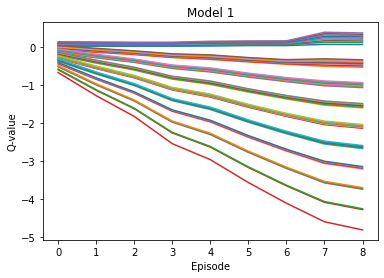

In [14]:
for i in [9]:
    for j in range(10):
        for k in [0]:
            for h in range(10):
                a = df01[(2,0,0,1,1,i,j,k,h)]
                a = a[~np.isnan(a)]
                ax = sns.lineplot(data=a)
                ax.set(xlabel="Episode", ylabel="Q-value")
                ax.set_title("Model 1")
plt.savefig(sInputFolder + '\\Training\\Converge1.2.png')

In [15]:
# Best Price Loop 01-01
df02 = h5f3[s][:]

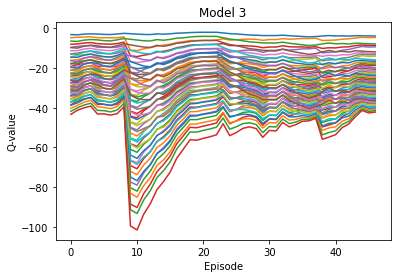

In [16]:
# convergence plot for simulated data of 2 weeks
actionSpace = np.arange(0, V + lot, lot)

# 'tradingVolBin', 'tradingImbBin', 'movingDiffBin', 'spreadBin', 'orderImbBin', time step, remaining shares, type of order, amount of order 
for i in [2]:
    for j in range(10):
        for k in [0]:
            for h in range(10):
                a = df02[(0,0,0,2,1,i,j,k,h)]
                a = a[~np.isnan(a)]
                ax = sns.lineplot(data=a)
                ax.set(xlabel="Episode", ylabel="Q-value")
                ax.set_title("Model 3")
plt.savefig(sInputFolder + '\\Training\\Converge3.1.png')

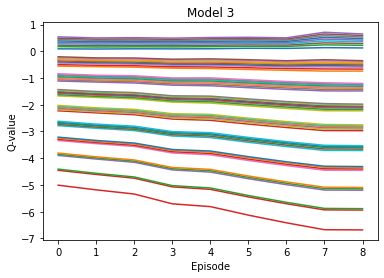

In [17]:
for i in [9]:
    for j in range(10):
        for k in [0]:
            for h in range(10):
                a = df02[(2,0,0,1,1,i,j,k,h)]
                a = a[~np.isnan(a)]
                ax = sns.lineplot(data=a)
                ax.set(xlabel="Episode", ylabel="Q-value")
                ax.set_title("Model 3")
plt.savefig(sInputFolder + '\\Training\\Converge3.2.png')

In [18]:
# Best Price 0.3
df03 = h5f2[s][:]
df03.shape

(3, 3, 3, 3, 3, 10, 11, 2, 11, 897)

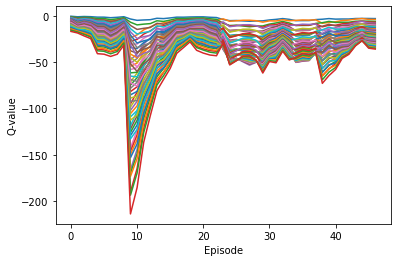

In [19]:
for i in [2]:
    for j in range(10):
        for k in [0]:
            for h in range(10):
                a = df03[(0,0,0,2,1,i,j,k,h)]
                a = a[~np.isnan(a)]
                ax = sns.lineplot(data=a)
                ax.set(xlabel="Episode", ylabel="Q-value")

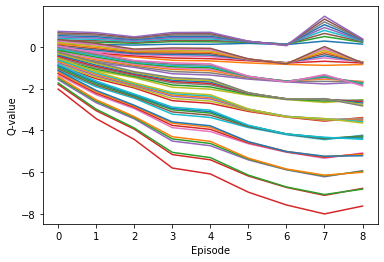

In [20]:
for i in [9]:
    for j in range(10):
        for k in [0]:
            for h in range(10):
                a = df03[(2,0,0,1,1,i,j,k,h)]
                a = a[~np.isnan(a)]
                ax = sns.lineplot(data=a)
                ax.set(xlabel="Episode", ylabel="Q-value")

In [21]:
# Best Price Loop 01-03
df04 = h5f4[s][:]

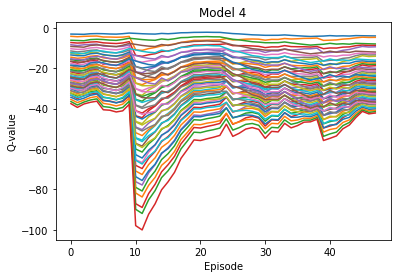

In [37]:
for i in [2]:
    for j in range(10):
        for k in [0]:
            for h in range(10):
                a = df04[(0,0,0,2,1,i,j,k,h)]
                a = a[~np.isnan(a)]
                ax = sns.lineplot(data=a)
                ax.set(xlabel="Episode", ylabel="Q-value")
                ax.set_title("Model 4")
plt.savefig(sInputFolder + '\\Training\\Converge4.1.png')

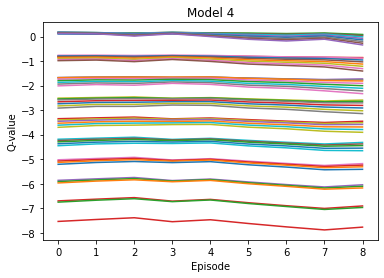

In [22]:
for i in [9]:
    for j in range(10):
        for k in [0]:
            for h in range(10):
                a = df04[(2,0,0,1,1,i,j,k,h)]
                a = a[~np.isnan(a)]
                ax = sns.lineplot(data=a)
                ax.set(xlabel="Episode", ylabel="Q-value")
                ax.set_title("Model 4")
plt.savefig(sInputFolder + '\\Training\\Converge4.2.png')